# Clase 8 - Taller Práctico: Clustering

**Objetivo:** En este taller, aplicaremos los tres algoritmos de clustering que vimos en la clase teórica para entender sus diferencias, fortalezas y debilidades en la práctica.

1.  **K-Means:** Ideal para clusters de forma esférica y cuando tenemos una idea del número de grupos.
2.  **Clustering Jerárquico:** Útil para explorar la estructura anidada de los datos sin pre-especificar el número de clusters.
3.  **DBSCAN:** Potente para descubrir clusters de formas arbitrarias y para identificar outliers (ruido).

Usaremos datasets sintéticos para tener un control total sobre la estructura de los datos y así evaluar visualmente el rendimiento de cada algoritmo.

In [1]:
# --- 1. Importación de Librerías ---
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# Funciones de Scikit-learn
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

# Funciones de SciPy para el dendrograma
from scipy.cluster.hierarchy import dendrogram, linkage

# Configuramos Plotly para que use un tema agradable
px.defaults.template = "plotly_dark"

## Sección 1: K-Means Clustering

Empezamos con K-Means, el algoritmo de clustering más popular. Para mostrar su funcionamiento, creamos un conjunto de datos con `make_blobs` que contiene grupos bien definidos y de forma esférica.

In [2]:
# --- 2. Generación y Visualización de Datos ---
# Creamos un dataset con 300 muestras, 4 centros (clusters) y una desviación estándar de 0.8
X_blobs, y_blobs = make_blobs(n_samples=300,
                              centers=4,
                              cluster_std=0.8,
                              random_state=42,
                              # centers=[[0, 0], [6, 6], [1, 7], [7, 0]],
                              # cluster_std=1.0,
                              )

# Visualizamos los datos sin etiquetas para simular un problema no supervisado
fig = px.scatter(x=X_blobs[:, 0], y=X_blobs[:, 1], title="Dataset Sintético (sin etiquetar)")
fig.update_traces(marker=dict(color='cyan'))
fig.show()

### 1.1 Determinando K: El Método del Codo

Antes de aplicar K-Means, debemos decidir el valor de `K`. El método del codo nos ayuda a encontrar un buen candidato para `K` al graficar la inercia (WCSS) para un rango de valores de `K`.

In [3]:
# --- 3. Implementación del Método del Codo ---
inertia_values = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_blobs)
    inertia_values.append(kmeans.inertia_)

# Graficamos los resultados
fig = px.line(x=k_range, y=inertia_values, title='Método del Codo para Encontrar K Óptimo',
              labels={'x': 'Número de Clusters (K)', 'y': 'Inercia (WCSS)'},
              markers=True)
fig.add_vline(x=4, line_width=3, line_dash="dash", line_color="red", annotation_text="Codo en K=4")
fig.show()

El gráfico muestra un "codo" claro en K=4, que es donde la tasa de disminución de la inercia se aplana. Esto sugiere que 4 es un buen número de clusters para nuestros datos, lo cual coincide con cómo los generamos.

### 1.2 Aplicando K-Means y Evaluando con el Coeficiente de Silueta

In [4]:
# --- 4. Aplicar K-Means con K=4 ---
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
kmeans_final.fit(X_blobs)

# Obtenemos las etiquetas de los clusters y los centroides
labels_kmeans = kmeans_final.labels_
centroids = kmeans_final.cluster_centers_

# Calculamos el coeficiente de silueta
silhouette_avg = silhouette_score(X_blobs, labels_kmeans)
print(f"Para K={optimal_k}, el coeficiente de silueta promedio es: {silhouette_avg:.4f}")

Para K=4, el coeficiente de silueta promedio es: 0.8335


Un coeficiente de silueta cercano a 1 indica que los clusters son densos y están bien separados. Nuestro valor es muy bueno.

In [5]:
# --- 5. Visualización de los Resultados de K-Means ---
df_blobs = pd.DataFrame(X_blobs, columns=['X1', 'X2'])
df_blobs['cluster_kmeans'] = labels_kmeans.astype(str) # Convertir a string para colores discretos

fig = px.scatter(df_blobs, x='X1', y='X2', color='cluster_kmeans', 
                 title='Resultados de K-Means Clustering (K=4)')

# Añadimos los centroides al gráfico
fig.add_trace(go.Scatter(x=centroids[:, 0], y=centroids[:, 1],
                          mode='markers', 
                          marker=dict(color='white', size=15, symbol='x'),
                          name='Centroides'))
fig.show()

## Sección 2: Clustering Jerárquico

Usemos el mismo dataset para aplicar clustering jerárquico. La principal ventaja aquí es el **dendrograma**, que nos permite visualizar la estructura anidada de los clusters.

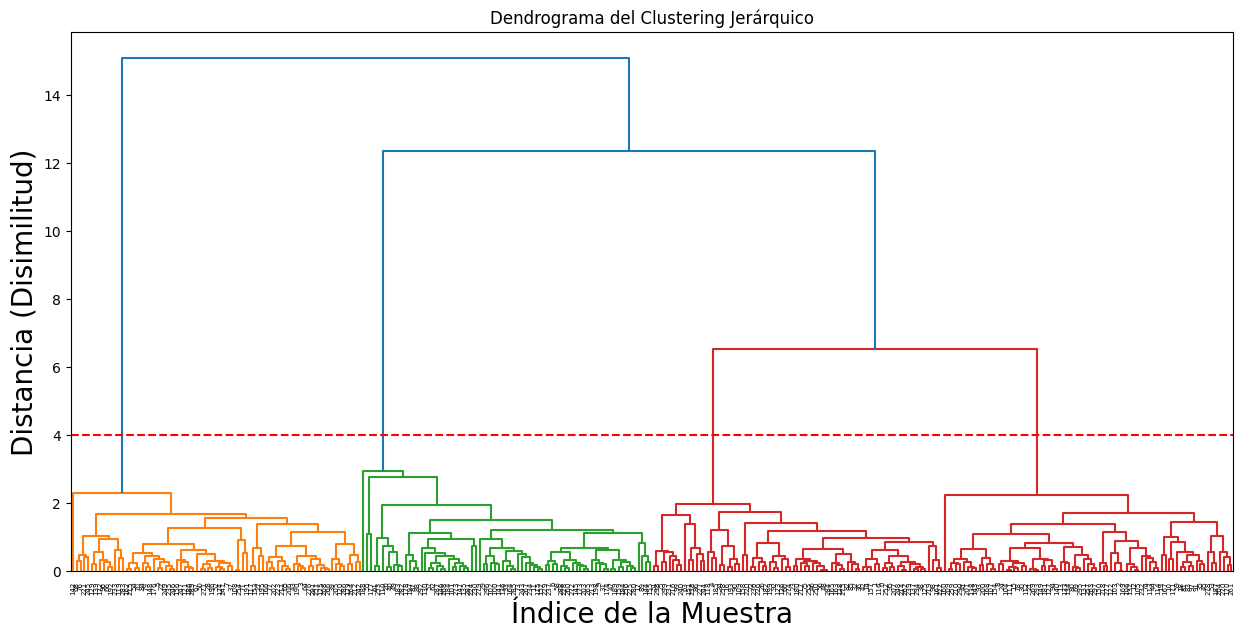

In [6]:
# --- 6. Creación del Dendrograma ---

# Usamos 'average' como método de enlace
linkage_matrix = linkage(X_blobs, method='average')

plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix)
plt.title('Dendrograma del Clustering Jerárquico')
plt.xlabel('Índice de la Muestra', fontsize=20)
plt.ylabel('Distancia (Disimilitud)', fontsize=20)
plt.axhline(y=4, color='r', linestyle='--') # Linea de corte para K=4
plt.show()

El dendrograma muestra que un corte horizontal en la región marcada (línea roja) resultaría en 4 clusters.

### 2.1 Aplicando Clustering Jerárquico Aglomerativo

In [7]:
# --- 7. Aplicar AgglomerativeClustering con 4 clusters ---
agg_cluster = AgglomerativeClustering(n_clusters=4, linkage='average')
labels_agg = agg_cluster.fit_predict(X_blobs)

# Visualizamos los resultados
df_blobs['cluster_agg'] = labels_agg.astype(str)

fig = px.scatter(df_blobs, x='X1', y='X2', color='cluster_agg', 
                 title='Resultados de Clustering Jerárquico (K=4)')
fig.show()

Para este tipo de datos, los resultados de K-Means y Clustering Jerárquico son muy similares, lo cual es de esperar.

## Sección 3: DBSCAN para Formas Complejas

¿Qué pasa cuando los clusters no son esféricos? Aquí es donde K-Means y otros métodos similares fallan. Usaremos el dataset `make_moons` para demostrar la superioridad de DBSCAN en estos escenarios.

In [8]:
# --- 8. Generar y escalar datos no esféricos ---
X_moons, y_moons = make_moons(n_samples=250, noise=0.1, random_state=42)

# DBSCAN es sensible a la escala, por lo que es crucial estandarizar los datos
scaler = StandardScaler()
X_moons_scaled = scaler.fit_transform(X_moons)

# Visualizamos los datos
fig = px.scatter(x=X_moons_scaled[:, 0], y=X_moons_scaled[:, 1], title='Dataset de las Dos Lunas')
fig.update_traces(marker=dict(color='lime'))
fig.show()

### 3.1 El Fracaso de K-Means

In [9]:
# --- 9. Aplicar K-Means a los datos de las lunas ---
kmeans_moons = KMeans(n_clusters=2, n_init=10, random_state=42)
labels_kmeans_moons = kmeans_moons.fit_predict(X_moons_scaled)

df_moons = pd.DataFrame(X_moons_scaled, columns=['X1', 'X2'])
df_moons['cluster_kmeans'] = labels_kmeans_moons.astype(str)

fig = px.scatter(df_moons, x='X1', y='X2', color='cluster_kmeans',
                 title='Resultado de K-Means en el Dataset de Lunas')
fig.show()

Como podemos ver, K-Means falla. Simplemente divide los datos por la mitad, ya que su suposición de clusters esféricos no se cumple.

### 3.2 El Éxito de DBSCAN

In [10]:
# --- 10. Aplicar DBSCAN a los datos de las lunas ---
# La elección de `eps` y `min_samples` es crucial.
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_moons_scaled)

# Los labels -1 corresponden a ruido/outliers
df_moons['cluster_dbscan'] = labels_dbscan.astype(str)

fig = px.scatter(df_moons, x='X1', y='X2', color='cluster_dbscan',
                 title='Resultado de DBSCAN en el Dataset de Lunas',
                 color_discrete_map={'-1': 'red', '0': 'cyan', '1': 'magenta'})
fig.show()

¡Éxito! DBSCAN identifica correctamente las dos lunas como clusters separados. También identifica algunos puntos como ruido (en rojo), lo cual es una de sus grandes ventajas.

## Sección 4: Desafíos y Ejercicios

Hora de experimentar. Utilizá este notebook como base para resolver los siguientes ejercicios.

1.  **K-Means - Variando Datos:** Volvé a generar los datos de `make_blobs`, pero esta vez con `cluster_std=1.5`. ¿Cómo afecta una mayor desviación estándar a los resultados de K-Means? ¿El coeficiente de silueta empeora? ¿Por qué?

2.  **K-Means - Importancia de `n_init`:** Ejecutá K-Means en los datos originales de `make_blobs` con `n_init=1` múltiples veces. ¿Obtienes siempre la misma inercia? Compara estos resultados con `n_init=10` o `n_init=20`.

3.  **K-Means - Silueta para K:** En lugar del método del codo, utilizá el coeficiente de silueta para encontrar el `K` óptimo. Itera a través de un rango de `K` (por ejemplo, de 2 a 10), calcula el `silhouette_score` para cada `K` y grafica los resultados. ¿El `K` que maximiza la silueta coincide con el del método del codo?

4.  **Jerárquico - Linkage:** Cambiá el método de enlace a `'single'` y `'complete'`. ¿Cómo cambian los dendrogramas? ¿Cuál te parece más interpretable para estos datos y por qué?

5.  **Jerárquico - Cortes del Dendrograma:** Utilizando el dendrograma original, modificá la altura del corte (`y` en `plt.axhline`) para obtener 2, 3 y 5 clusters. Describí qué grupos se fusionan o se dividen en cada paso.

6.  **Aplicación General - Dataset Iris:** Importá el famoso dataset Iris de `sklearn.datasets`. Contiene 3 clases de flores. Aplica K-Means (con K=3), Clustering Jerárquico (cortando para obtener 3 clusters) y DBSCAN. ¿Cuál funciona mejor y por qué?

7.  **DBSCAN - Hiperparámetros:** Experimentá con diferentes valores de `eps` (ej. 0.1, 0.5, 1.0) y `min_samples` (ej. 2, 10, 20). ¿Cómo afectan los resultados? ¿Qué pasa si `eps` es muy grande o muy pequeño?